In [1]:
!pip install dask[complete] torch_geometric

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd

In [3]:
df = dd.read_csv("HI-Medium_Trans.csv")


In [4]:
data = df.compute()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31898238 entries, 0 to 679783
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           string 
 1   From Bank           int64  
 2   Account             string 
 3   To Bank             int64  
 4   Account.1           string 
 5   Amount Received     float64
 6   Receiving Currency  string 
 7   Amount Paid         float64
 8   Payment Currency    string 
 9   Payment Format      string 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), string(6)
memory usage: 3.8 GB


In [6]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

In [7]:
data.rename(columns = {'Account':'From acc'}, inplace = True)
data.rename(columns = {'Account.1':'To acc'}, inplace = True)

In [8]:
data.head()

,Timestamp,From Bank,From acc,To Bank,To acc,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022-09-01 00:17:00,20,800104D70,20,800104D70,6794.63,US Dollar,6794.63,US Dollar,Reinvestment,0
1,2022-09-01 00:02:00,3196,800107150,3196,800107150,7739.29,US Dollar,7739.29,US Dollar,Reinvestment,0
2,2022-09-01 00:17:00,1208,80010E430,1208,80010E430,1880.23,US Dollar,1880.23,US Dollar,Reinvestment,0
3,2022-09-01 00:03:00,1208,80010E650,20,80010E6F0,73966883.00,US Dollar,73966883.00,US Dollar,Cheque,0
4,2022-09-01 00:02:00,1208,80010E650,20,80010EA30,45868454.00,US Dollar,45868454.00,US Dollar,Cheque,0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31898238 entries, 0 to 679783
Data columns (total 11 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Timestamp           datetime64[ns]
 1   From Bank           int64         
 2   From acc            string        
 3   To Bank             int64         
 4   To acc              string        
 5   Amount Received     float64       
 6   Receiving Currency  string        
 7   Amount Paid         float64       
 8   Payment Currency    string        
 9   Payment Format      string        
 10  Is Laundering       int64         
dtypes: datetime64[ns](1), float64(2), int64(3), string(5)
memory usage: 3.5 GB


In [10]:
print(data.isnull().sum())


Timestamp             0
From Bank             0
From acc              0
To Bank               0
To acc                0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
dtype: int64


In [11]:
print(data.shape)

(31898238, 11)


In [12]:
data = data.drop_duplicates(keep = 'first')
data.shape

(31898218, 11)

In [13]:
data.nunique()

Timestamp               26086
From Bank              122330
From acc              2013627
To Bank                 62820
To acc                1689925
Amount Received       2824359
Receiving Currency         15
Amount Paid           2850751
Payment Currency           15
Payment Format              7
Is Laundering               2
dtype: int64

In [14]:
data['Year'] = data['Timestamp'].dt.year
data['Month'] = data['Timestamp'].dt.month

In [15]:
Laundering = data[data['Is Laundering']==1]
Non_Laundering = data[data['Is Laundering']==0]

In [16]:
print(len(Laundering))
print(len(Non_Laundering))

35230
31862988


In [17]:
Laundering.nunique()

Timestamp             19455
From Bank              4108
From acc              22772
To Bank                4589
To acc                26629
Amount Received       34052
Receiving Currency       15
Amount Paid           34052
Payment Currency         15
Payment Format            5
Is Laundering             1
Year                      1
Month                     1
dtype: int64

In [18]:
inter_currency_transactionsL = Laundering[Laundering['Receiving Currency'] != Laundering['Payment Currency']]
inter_currencyL = inter_currency_transactionsL.groupby(['Receiving Currency', 'Payment Currency']).size().reset_index(name='Transaction Count')
inter_currencyL.describe()

,Transaction Count
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [19]:
same_currency_transactionsL = Laundering[Laundering['Receiving Currency'] == Laundering['Payment Currency']]
same_currencyL = same_currency_transactionsL.groupby('Payment Currency').size().reset_index(name='Transaction Count')

same_currencyL.describe()

,Transaction Count
count,15.000000
mean,2348.666667
std,4070.513967
min,224.000000
25%,338.000000
50%,737.000000
75%,1543.000000
max,14292.000000


In [20]:
same_currencyL

,Payment Currency,Transaction Count
0,Australian Dollar,737
1,Bitcoin,244
2,Brazil Real,279
3,Canadian Dollar,605
4,Euro,9710
5,Mexican Peso,346
6,Ruble,1457
7,Rupee,830
8,Saudi Riyal,224
9,Shekel,658


In [21]:
same_currL = data[data['Receiving Currency'] == data['Payment Currency']]
cross_currL = data[data['Receiving Currency'] != data['Payment Currency']]
same_count = len(same_currL)
cross_count = len(cross_currL)

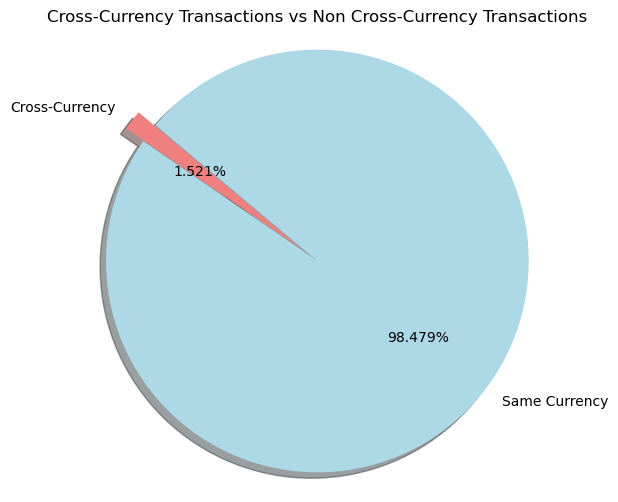

In [22]:
labels = ['Cross-Currency', 'Same Currency']
sizes = [cross_count, same_count]
colors = ['lightcoral', 'lightblue']
explode = (0.1, 0)

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.3f%%', shadow=True, startangle=140)
plt.title('Cross-Currency Transactions vs Non Cross-Currency Transactions')
plt.axis('equal')
plt.show()

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


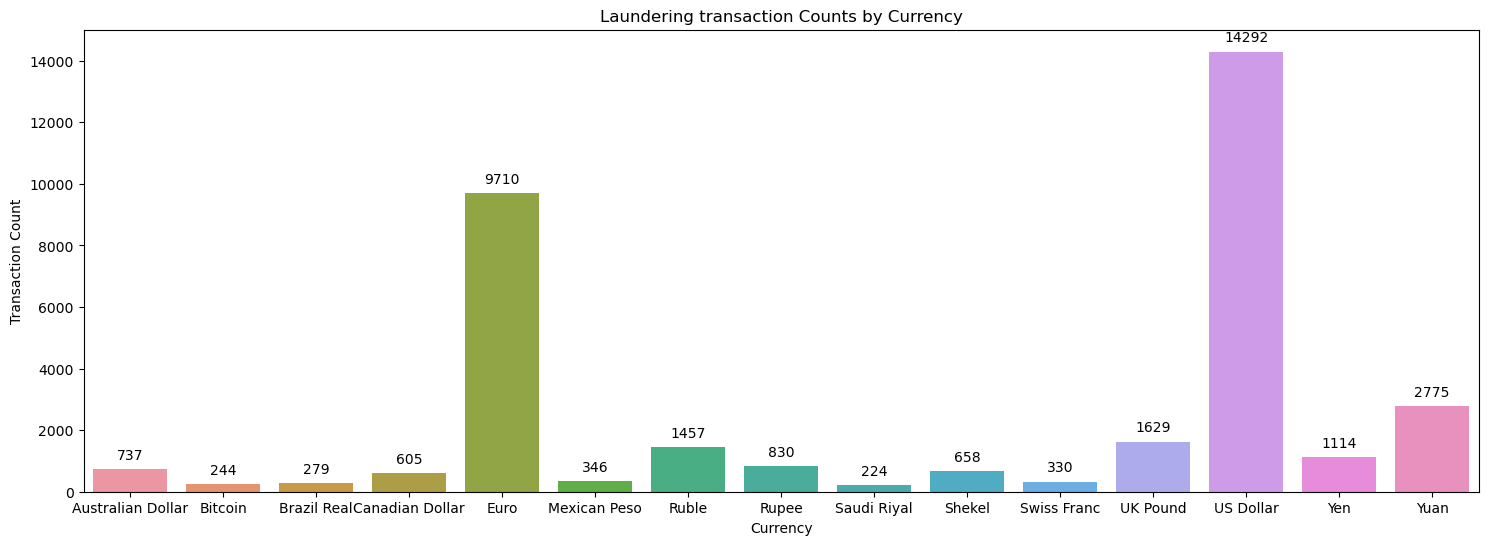

In [23]:
plt.figure(figsize=(18, 6))
ax=sns.barplot(x='Payment Currency', y='Transaction Count', data=same_currencyL)
plt.title('Laundering transaction Counts by Currency')
plt.xlabel('Currency')
plt.ylabel('Transaction Count')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.show()


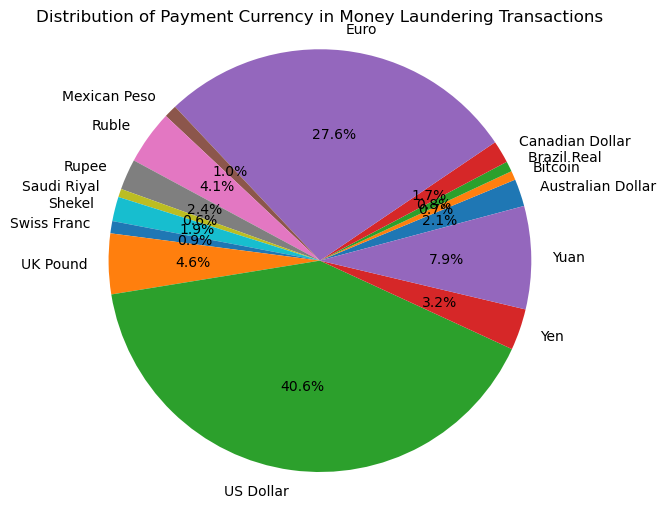

In [24]:
plt.figure(figsize=(6, 6))
plt.pie(same_currencyL['Transaction Count'], labels=same_currencyL['Payment Currency'], autopct='%1.1f%%', startangle=15)
plt.title('Distribution of Payment Currency in Money Laundering Transactions')
plt.axis('equal')
plt.show()

In [25]:
payment_format_data = data.groupby('Payment Format').size().reset_index(name='Transaction Count')
payment_format_data.head().sort_values(by=['Transaction Count'],ascending=False)

,Payment Format,Transaction Count
3,Cheque,12280058
4,Credit Card,8777816
0,ACH,3868404
2,Cash,3217531
1,Bitcoin,689025


In [26]:
payment_formatL = Laundering.groupby('Payment Format').size().reset_index(name='Transaction Count')
payment_formatL.head().sort_values(by=['Transaction Count'],ascending=False)

,Payment Format,Transaction Count
0,ACH,30746
3,Cheque,2220
4,Credit Card,1354
2,Cash,666
1,Bitcoin,244


/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


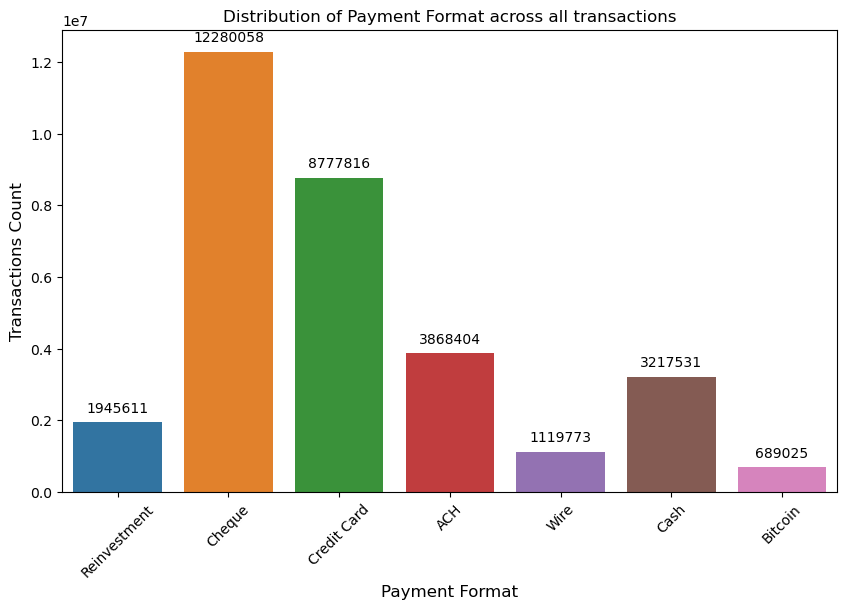

In [27]:
fig, axes = plt.subplots(figsize=(10,6))

sns.countplot(x='Payment Format',data=data, ax=axes)
axes.set_title('Distribution of Payment Format across all transactions')
axes.set_xlabel('Payment Format', fontsize=12)
axes.set_ylabel('Transactions Count', fontsize=12)
axes.tick_params(axis='x', labelrotation=45) 
for p in axes.patches:
    axes.annotate(format(p.get_height(), '.0f'), 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')


plt.show()

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


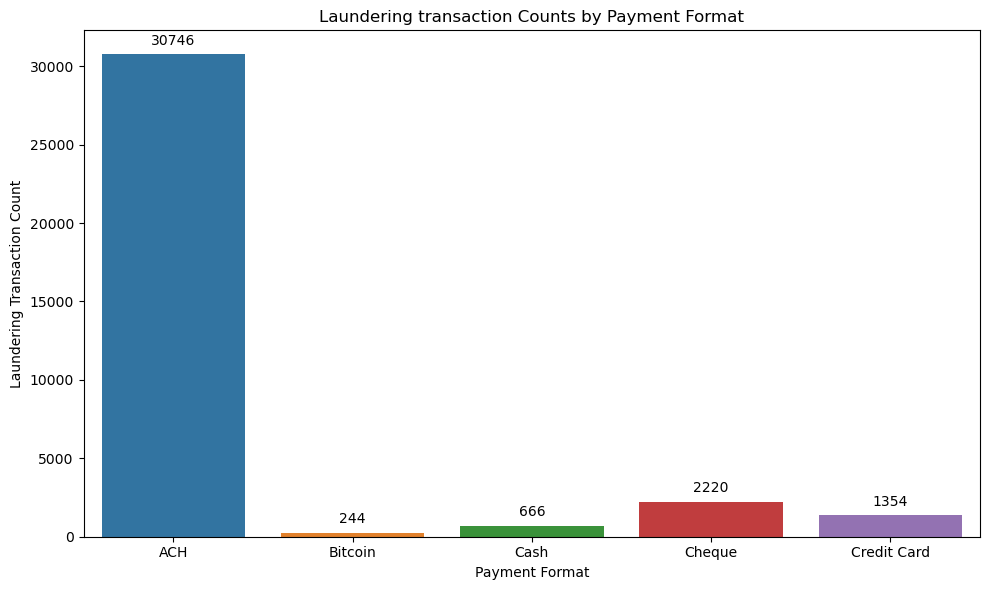

In [28]:

fig, axes = plt.subplots(figsize=(10,6))

sns.barplot(x='Payment Format', y='Transaction Count', data=payment_formatL,ax=axes)
axes.set_title('Laundering transaction Counts by Payment Format')
axes.set_xlabel('Payment Format')
axes.set_ylabel('Laundering Transaction Count')
plt.tight_layout()

for p in axes.patches:
    axes.annotate(format(p.get_height(), '.0f'), 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')

plt.show()

(-1.0999999643463694,
 1.099999998302208,
 -1.0999999031604801,
 1.099999804316355)

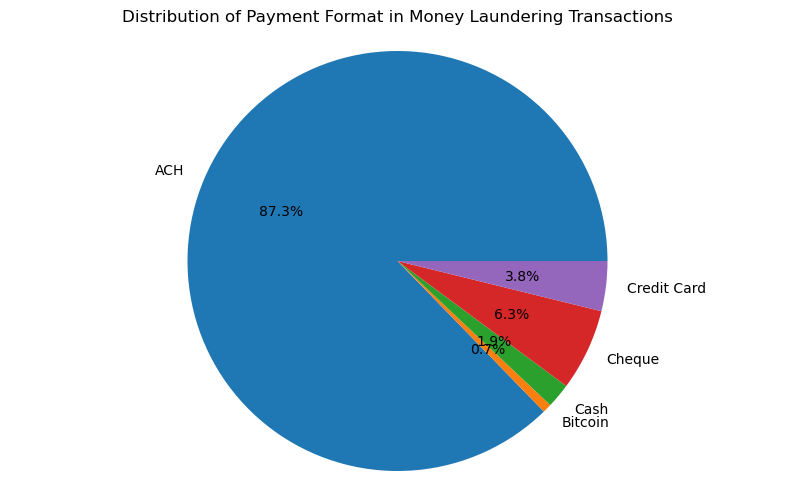

In [29]:
fig, ax = plt.subplots(figsize=(10,6))

ax.pie(payment_formatL['Transaction Count'], labels=payment_formatL['Payment Format'], autopct='%1.1f%%', startangle=0)
ax.set_title('Distribution of Payment Format in Money Laundering Transactions')
ax.axis('equal')

/tmp/ipykernel_1402/1191750622.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Laundering['Timestamp'] = pd.to_datetime(Laundering['Timestamp'])
/tmp/ipykernel_1402/1191750622.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Laundering['Day'] = Laundering['Timestamp'].dt.day


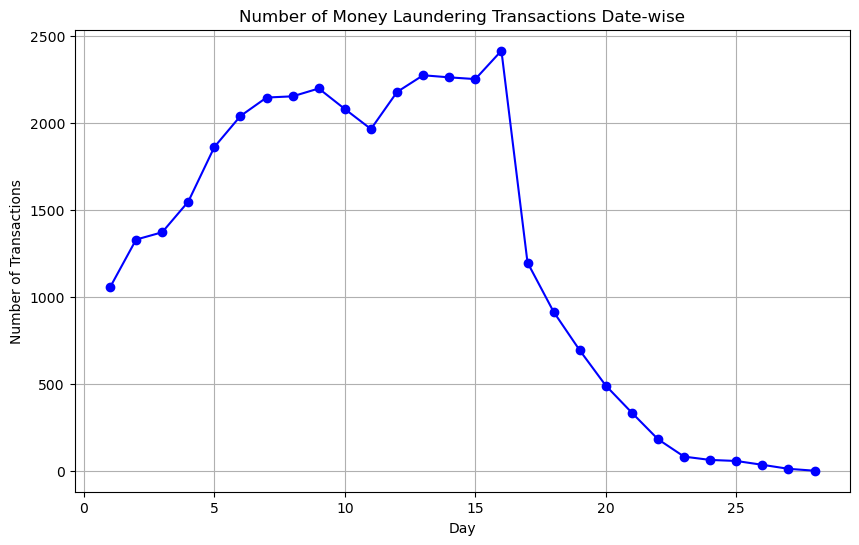

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

Laundering['Timestamp'] = pd.to_datetime(Laundering['Timestamp'])
Laundering['Day'] = Laundering['Timestamp'].dt.day
daily_transactions = Laundering.groupby('Day').size()

daily_transactions.plot(kind='line', marker='o', color='b', figsize=(10, 6))
plt.title('Number of Money Laundering Transactions Date-wise')
plt.xlabel('Day')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

/tmp/ipykernel_1402/1252191665.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Non_Laundering['Timestamp'] = pd.to_datetime(Non_Laundering['Timestamp'])
/tmp/ipykernel_1402/1252191665.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Non_Laundering['Day'] = Non_Laundering['Timestamp'].dt.day


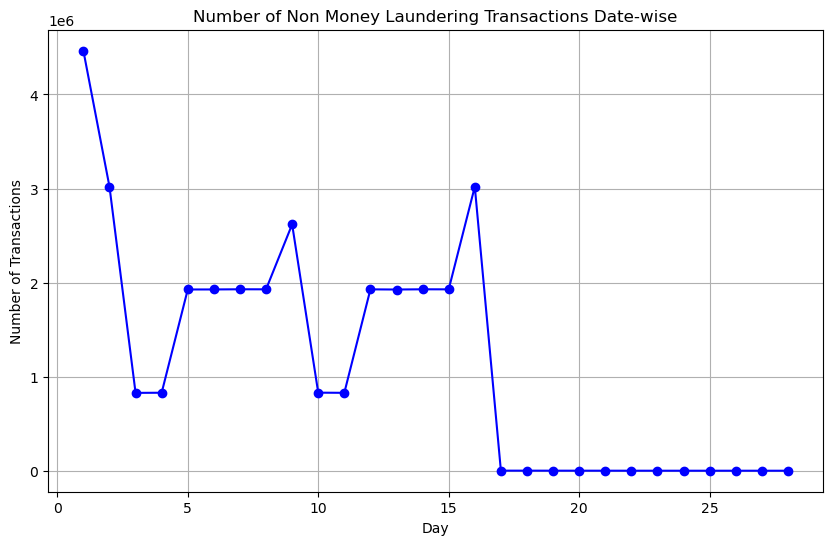

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

Non_Laundering['Timestamp'] = pd.to_datetime(Non_Laundering['Timestamp'])
Non_Laundering['Day'] = Non_Laundering['Timestamp'].dt.day
daily_transactions = Non_Laundering.groupby('Day').size()

daily_transactions.plot(kind='line', marker='o', color='b', figsize=(10, 6))
plt.title('Number of Non Money Laundering Transactions Date-wise')
plt.xlabel('Day')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

In [32]:
string_cols = data.select_dtypes(include=['string']).columns.tolist()
string_cols


['From acc',
 'To acc',
 'Receiving Currency',
 'Payment Currency',
 'Payment Format']

In [33]:
for col in string_cols:
    print(col,'\n')
    print(data[col].nunique(), '\n')
    print(data[col].value_counts())

From acc 

2013627 

From acc
100428660    1076979
1004286A8     678929
1004286F0     208695
1004289C0     132783
100428858     102358
              ...   
838DAA880          1
83D234540          1
8432CBD30          1
8521BB2E1          1
8521E8FF1          1
Name: count, Length: 2013627, dtype: int64[pyarrow]
To acc 

1689925 

To acc
100428660    6842
1004286A8    4304
1004286F0    1539
1004289C0     855
100428858     637
             ... 
800DA10F0       1
82B61A300       1
82792FFE0       1
82F846A80       1
81949BC00       1
Name: count, Length: 1689925, dtype: int64[pyarrow]
Receiving Currency 

15 

Receiving Currency
US Dollar            11594241
Euro                  7329169
Yuan                  2295849
Shekel                1428622
Canadian Dollar       1089398
UK Pound              1020042
Ruble                  989319
Australian Dollar      931364
Yen                    860154
Swiss Franc            856680
Mexican Peso           852272
Rupee                  741594
Bitcoi

In [34]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder


In [35]:
# Select columns of type 'string'
string_cols = data.select_dtypes(include=['string']).columns.tolist()
print(string_cols)

# Quantify columns of type 'string' using Label Encoding
label_encoder = LabelEncoder()
for col in string_cols:
    if col != 'Payment Format':
        data[col] = label_encoder.fit_transform(data[col])

# Sort based on the complexity of payment
payment_map = {'Cash': 1, 'Cheque': 2, 'ACH': 3, 'Credit Card': 4, 'Wire': 5, 'Bitcoin': 6, 'Reinvestment': 7}

# Use the map method to encode the 'Payment Format' column
data['Payment Format'] = data['Payment Format'].map(payment_map)

# Output the processed data
data.head()


['From acc', 'To acc', 'Receiving Currency', 'Payment Currency', 'Payment Format']


,Timestamp,From Bank,From acc,To Bank,To acc,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Year,Month
0,2022-09-01 00:17:00,20,963,20,926,6794.63,12,6794.63,12,7,0,2022,9
1,2022-09-01 00:02:00,3196,976,3196,939,7739.29,12,7739.29,12,7,0,2022,9
2,2022-09-01 00:17:00,1208,1020,1208,979,1880.23,12,1880.23,12,7,0,2022,9
3,2022-09-01 00:03:00,1208,1023,20,983,73966883.00,12,73966883.00,12,2,0,2022,9
4,2022-09-01 00:02:00,1208,1023,20,985,45868454.00,12,45868454.00,12,2,0,2022,9


In [36]:
# Normalizing all attributes

# Separating labels from the dataset
labels = data['Is Laundering']
data = data.drop('Is Laundering', axis=1)

# Converting the Timestamp column to Unix timestamp

data['Timestamp'] = pd.to_datetime(data['Timestamp']).astype(int) / 10**9

# Normalizing the dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data)
data_normalized = scaler.transform(data)

# Converting the normalized data back to a DataFrame object and setting column names
data_normalized = pd.DataFrame(data_normalized, columns=data.columns)

# Adding the label column back to the normalized dataset
data_normalized['Is Laundering'] = labels.tolist()

# Outputting the normalized data
print(data_normalized.head())


   Timestamp  From Bank  From acc   To Bank    To acc  Amount Received  \
0  -0.999147  -0.999988 -0.999044 -0.999988 -0.998904        -1.000000   
1  -0.999900  -0.998018 -0.999031 -0.998018 -0.998889        -1.000000   
2  -0.999147  -0.999251 -0.998987 -0.999251 -0.998841        -1.000000   
3  -0.999849  -0.999251 -0.998984 -0.999988 -0.998837        -0.999982   
4  -0.999900  -0.999251 -0.998984 -0.999988 -0.998834        -0.999989   

   Receiving Currency  Amount Paid  Payment Currency  Payment Format  Year  \
0            0.714286    -1.000000          0.714286        1.000000  -1.0   
1            0.714286    -1.000000          0.714286        1.000000  -1.0   
2            0.714286    -1.000000          0.714286        1.000000  -1.0   
3            0.714286    -0.999982          0.714286       -0.666667  -1.0   
4            0.714286    -0.999989          0.714286       -0.666667  -1.0   

   Month  Is Laundering  
0   -1.0              0  
1   -1.0              0  
2   -1.0

In [37]:
data_normalized=data_normalized.drop(['Month', 'Year'], axis=1)


In [38]:
data_normalized.head()

,Timestamp,From Bank,From acc,To Bank,To acc,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,-0.999147,-0.999988,-0.999044,-0.999988,-0.998904,-1.000000,0.714286,-1.000000,0.714286,1.000000,0
1,-0.999900,-0.998018,-0.999031,-0.998018,-0.998889,-1.000000,0.714286,-1.000000,0.714286,1.000000,0
2,-0.999147,-0.999251,-0.998987,-0.999251,-0.998841,-1.000000,0.714286,-1.000000,0.714286,1.000000,0
3,-0.999849,-0.999251,-0.998984,-0.999988,-0.998837,-0.999982,0.714286,-0.999982,0.714286,-0.666667,0
4,-0.999900,-0.999251,-0.998984,-0.999988,-0.998834,-0.999989,0.714286,-0.999989,0.714286,-0.666667,0


In [39]:
data_normalized.columns

Index(['Timestamp', 'From Bank', 'From acc', 'To Bank', 'To acc',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering'],
      dtype='object')

In [40]:
from sklearn.model_selection import KFold, StratifiedKFold

X = data_normalized.drop('Is Laundering', axis=1)
y = data_normalized['Is Laundering']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

    # We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
    # original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

    # Check the Distribution of the labels


    # Turn into an array
    original_Xtrain = original_Xtrain.values
    original_Xtest = original_Xtest.values
    original_ytrain = original_ytrain.values
    original_ytest = original_ytest.values

    # See if both the train and test label distribution are similarly distributed
    train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
    test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
    print('-' * 100)

    print('Label Distributions: \n')
    print(train_counts_label/ len(original_ytrain))
    print(test_counts_label/ len(original_ytest))

Train: [ 6376206  6376207  6376208 ... 31898215 31898216 31898217] Test: [      0       1       2 ... 8559491 8559492 8559494]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99889555 0.00110445]
[0.99889555 0.00110445]
Train: [       0        1        2 ... 31898215 31898216 31898217] Test: [ 6376206  6376207  6376208 ... 14081773 14083741 14084510]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99889555 0.00110445]
[0.99889555 0.00110445]
Train: [       0        1        2 ... 31898215 31898216 31898217] Test: [12757759 12757760 12757761 ... 20078867 20078869 20078871]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99889555 0.00110445]
[0.99889555 0.00110445]
Train: [       0        1        2 ... 31898215 31898216 31898217] Test: [19137300 19137301

In [41]:

# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

data_normalized = data_normalized.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = data_normalized.loc[data_normalized['Is Laundering'] == 1]
non_fraud_df = data_normalized.loc[data_normalized['Is Laundering'] == 0][:len(fraud_df)]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Timestamp,From Bank,From acc,To Bank,To acc,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
10482058,-0.662081,-0.888638,0.842252,-0.912918,0.835858,-1.0,-0.428571,-1.0,-0.428571,-0.333333,1
20128166,-0.219840,-0.931227,-0.881507,-0.991416,-0.959247,-1.0,0.714286,-1.0,0.714286,-0.333333,1
14472808,-0.512476,-0.887109,0.708562,-0.878621,0.773713,-1.0,0.285714,-1.0,0.285714,-0.333333,0
30935530,0.134043,-0.999991,-0.847128,-0.999062,-0.839147,-1.0,-0.428571,-1.0,-0.428571,-0.666667,0
27401985,0.117777,-0.998568,-0.993650,-0.999999,-0.999782,-1.0,-0.428571,-1.0,-0.428571,-0.333333,1


Distribution of the Is_Launderinges in the subsample dataset
Is Laundering
1    0.5
0    0.5
Name: count, dtype: float64


/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


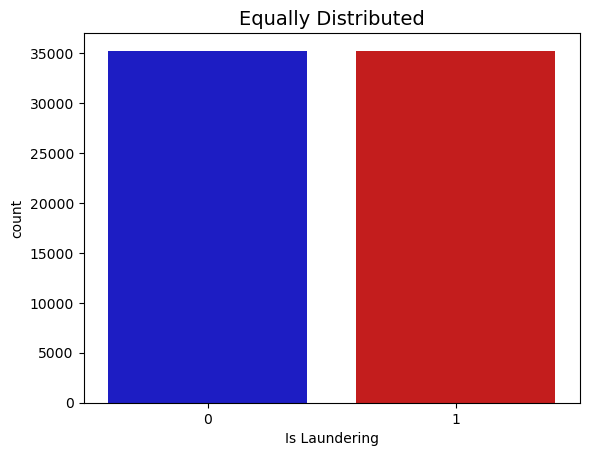

In [42]:
print('Distribution of the Is_Launderinges in the subsample dataset')
print(new_df['Is Laundering'].value_counts()/len(new_df))

colors = ["#0101DF", "#DF0101"]
sns.countplot(data=new_df, x='Is Laundering', palette=colors)
plt.title('Equally Distributed', fontsize=14)
plt.show()

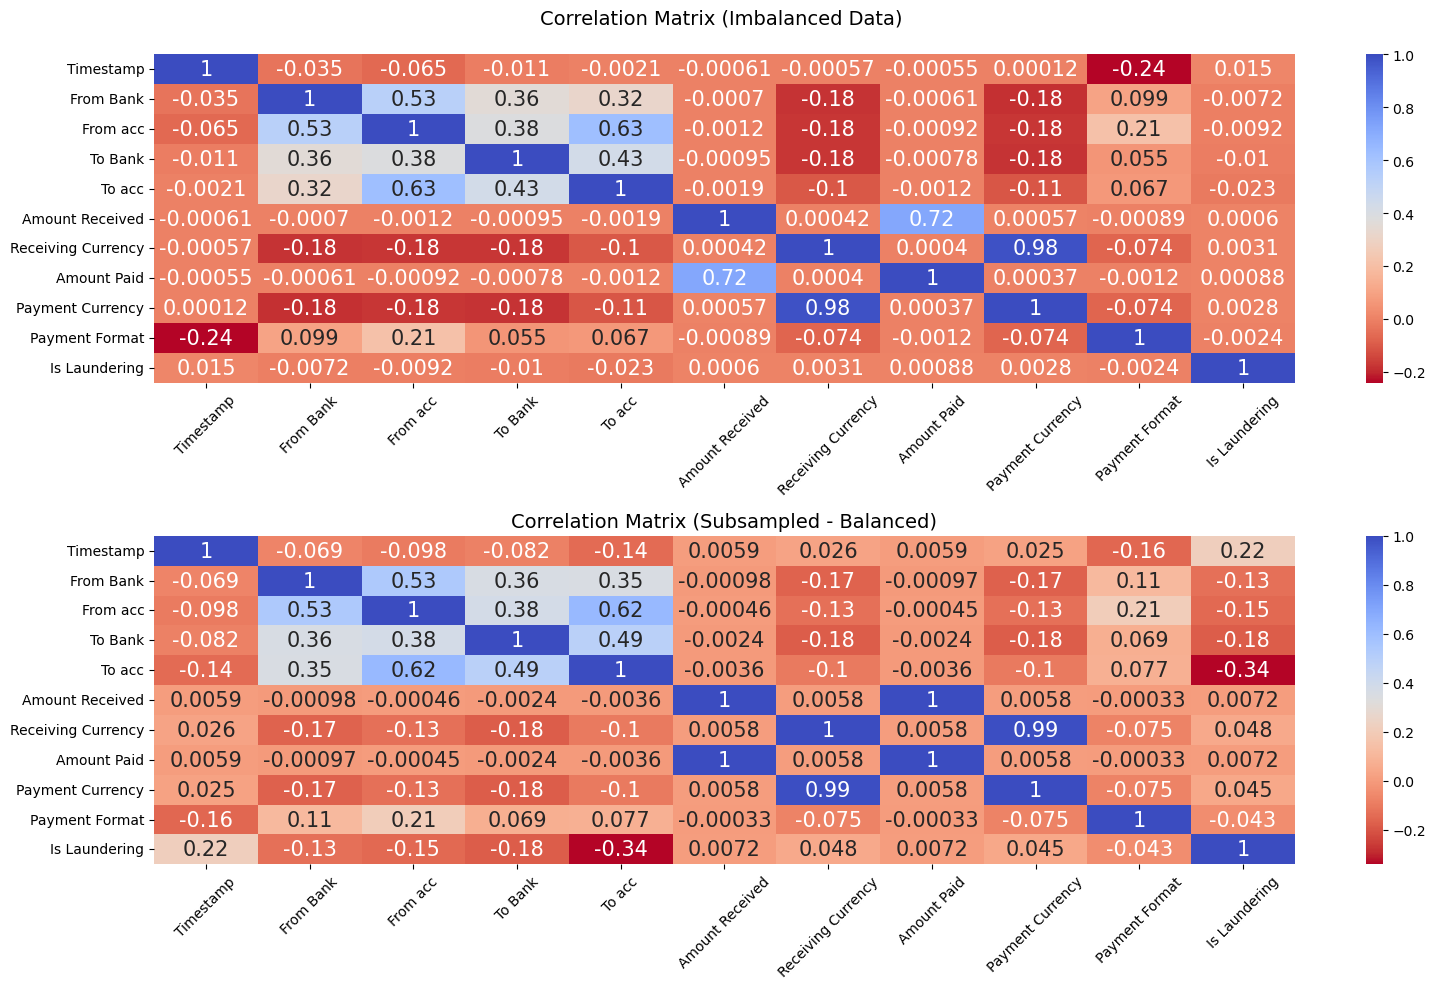

In [85]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,10))

# Entire DataFrame
corr = data_normalized.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot=True, annot_kws={'size':15}, ax=ax1)
ax1.set_title("Correlation Matrix (Imbalanced Data) \n ", fontsize=14)
ax1.tick_params(axis='x', labelrotation=45) # rotate x-axis labels

# Subsampled Dataset
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot=True, annot_kws={'size':15}, ax=ax2)
ax2.set_title('Correlation Matrix (Subsampled - Balanced)', fontsize=14)
ax2.tick_params(axis='x', labelrotation=45) # rotate x-axis labels
plt.tight_layout()
plt.show()


/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

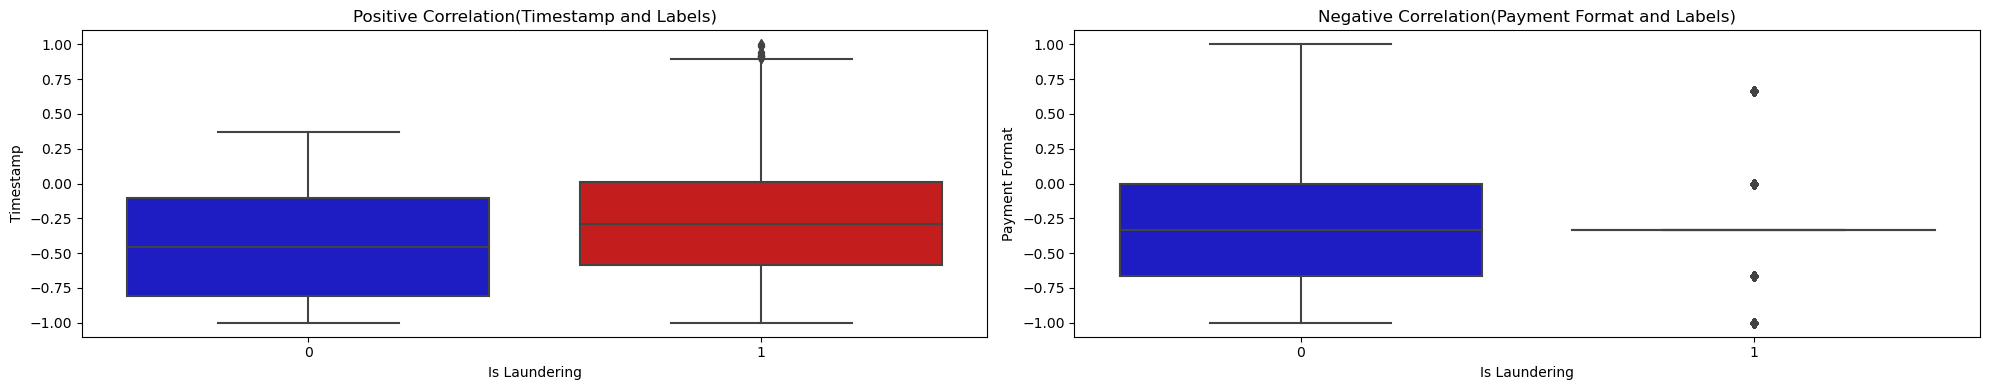

In [44]:
f, axes = plt.subplots(ncols=2, figsize=(20,4))
sns.boxplot(x="Is Laundering", y="Timestamp", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('Positive Correlation(Timestamp and Labels)')
sns.boxplot(x="Is Laundering", y="Payment Format", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('Negative Correlation(Payment Format and Labels)')

plt.tight_layout()
plt.show()

/tmp/ipykernel_1402/2769215977.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Timestamp_fraud_dist,ax=ax, fit=norm, color='#FB8861')
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', T

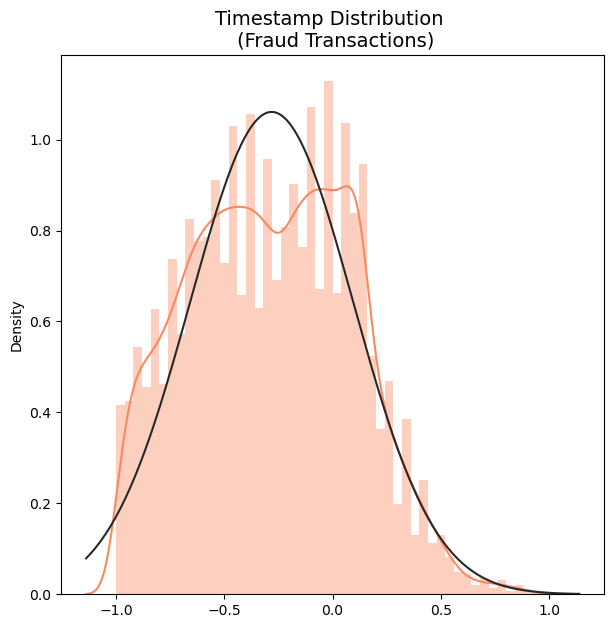

In [45]:
from scipy.stats import norm

f, ax = plt.subplots(figsize=(7, 7))

Timestamp_fraud_dist = new_df['Timestamp'].loc[new_df['Is Laundering'] == 1].values
sns.distplot(Timestamp_fraud_dist,ax=ax, fit=norm, color='#FB8861')
ax.set_title('Timestamp Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [48]:
Timestamp_fraud = new_df['Timestamp'].loc[new_df['Is Laundering'] == 1].values
q25, q75 = np.percentile(Timestamp_fraud, 25), np.percentile(Timestamp_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
Timestamp_iqr = q75 - q25
print('iqr: {}'.format(Timestamp_iqr))

Timestamp_cut_off = Timestamp_iqr * 1.5
Timestamp_lower, Timestamp_upper = q25 - Timestamp_cut_off, q75 + Timestamp_cut_off
print('Cut Off: {}'.format(Timestamp_cut_off))
print('Timestamp Lower: {}'.format(Timestamp_lower))
print('Timestamp Upper: {}'.format(Timestamp_upper))

outliers = [x for x in Timestamp_fraud if x < Timestamp_lower or x > Timestamp_upper]
print('Feature Timestamp Outliers for Fraud Cases: {}'.format(len(outliers)))
print('Timestamp outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['Timestamp'] > Timestamp_upper) | (new_df['Timestamp'] < Timestamp_lower)].index)

new_df.head()

Quartile 25: -0.5846177016917409 | Quartile 75: 0.008923640745024386
iqr: 0.5935413424367653
Cut Off: 0.8903120136551479
Timestamp Lower: -1.4749297153468888
Timestamp Upper: 0.8992356544001723
Feature Timestamp Outliers for Fraud Cases: 13
Timestamp outliers:[0.9880014056930122, 0.9144033335007862, 0.9228876951654001, 0.9092825945076584, 0.9007982328430444, 0.9887544555449495, 0.9129976404437912, 0.9179175661429326, 1.0, 0.8997439630504687, 0.941161704904971, 0.9024047391937984, 0.9342336462673302]


,Timestamp,From Bank,From acc,To Bank,To acc,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
27648128,0.037100,-0.860575,-0.405910,-0.969049,-0.416278,-1.0,-0.428571,-1.0,-0.428571,-0.333333,1
21610820,-0.188363,-0.990497,-0.806800,-0.995281,-0.909523,-1.0,-0.428571,-1.0,-0.428571,-0.333333,1
5604281,-0.901451,-0.989112,-0.927976,-0.989112,-0.929636,-1.0,-0.428571,-1.0,0.714286,-0.333333,0
10122048,-0.674883,0.322422,0.822538,-0.916046,0.827248,-1.0,0.714286,-1.0,0.714286,-0.666667,0
9487648,-0.700136,-0.927553,-0.520243,-0.996427,-0.530101,-1.0,0.714286,-1.0,0.714286,-0.333333,1


In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def run(data):
    # Undersampling before cross-validating (prone to overfit)
    X = data.drop('Is Laundering', axis=1)
    y = data['Is Laundering']
    
    # Splitting our data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Classifiers dictionary
    classifiers = {
        "Logistic Regression": LogisticRegression(),
        "Support Vector Classifier": SVC(),
        "Random Forest Classifier": RandomForestClassifier()
    }
    
    # Train and evaluate each classifier
    for key, classifier in classifiers.items():
        classifier.fit(X_train, y_train)
        y_train_pred = classifier.predict(X_train)
        y_test_pred = classifier.predict(X_test)
        
        # Calculating training and testing scores
        train_score = accuracy_score(y_train, y_train_pred)
        test_score = accuracy_score(y_test, y_test_pred)
        
        # Output the scores
        print(f"\nClassifier: {key}")
        print(f"Training Score: {train_score:.2f}")
        print(f"Test Score: {test_score:.2f}")
        
        # Classification report
        print("Classification Report:")
        print(classification_report(y_test, y_test_pred))
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_test_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Non-Laundering', 'Laundering'], 
                    yticklabels=['Non-Laundering', 'Laundering'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix for {key}')
        plt.show()


In [65]:
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Is Laundering', axis=1)
y = new_df['Is Laundering']



# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))


PCA took 1.1 s


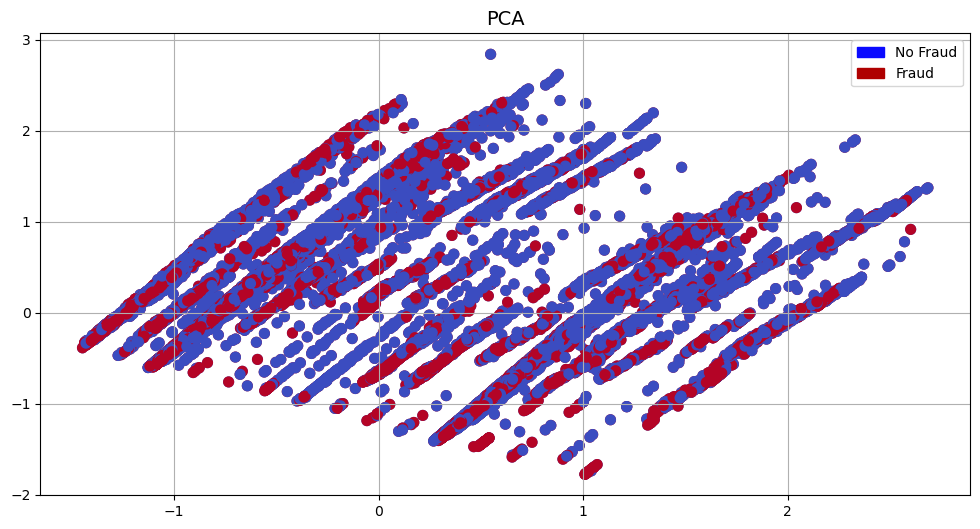

In [71]:
# import matplotlib.patches as mpatches

fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')



# PCA scatter plot
ax1.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('PCA', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])





Classifier: Logistic Regression
Training Score: 0.68
Test Score: 0.68
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.64      0.66     10532
           1       0.67      0.71      0.69     10606

    accuracy                           0.68     21138
   macro avg       0.68      0.68      0.68     21138
weighted avg       0.68      0.68      0.68     21138



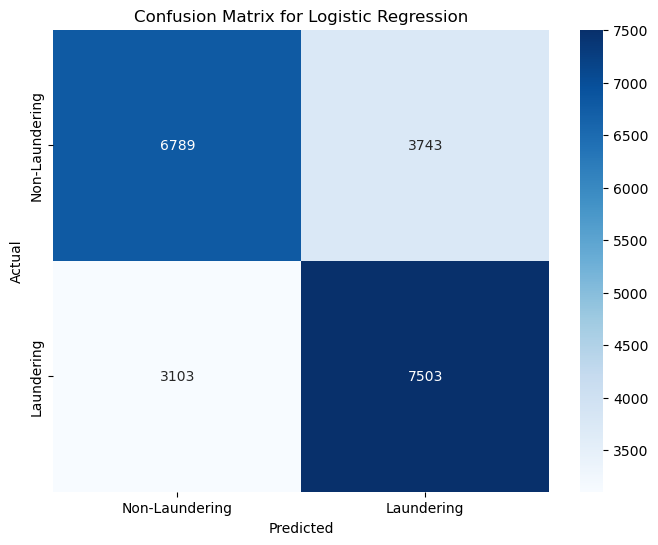


Classifier: Support Vector Classifier
Training Score: 0.89
Test Score: 0.89
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     10532
           1       0.89      0.89      0.89     10606

    accuracy                           0.89     21138
   macro avg       0.89      0.89      0.89     21138
weighted avg       0.89      0.89      0.89     21138



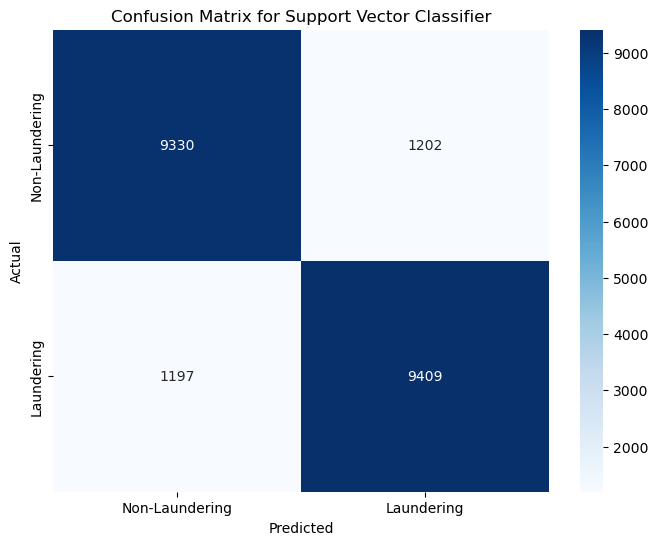


Classifier: Random Forest Classifier
Training Score: 1.00
Test Score: 0.90
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     10532
           1       0.87      0.94      0.91     10606

    accuracy                           0.90     21138
   macro avg       0.91      0.90      0.90     21138
weighted avg       0.91      0.90      0.90     21138



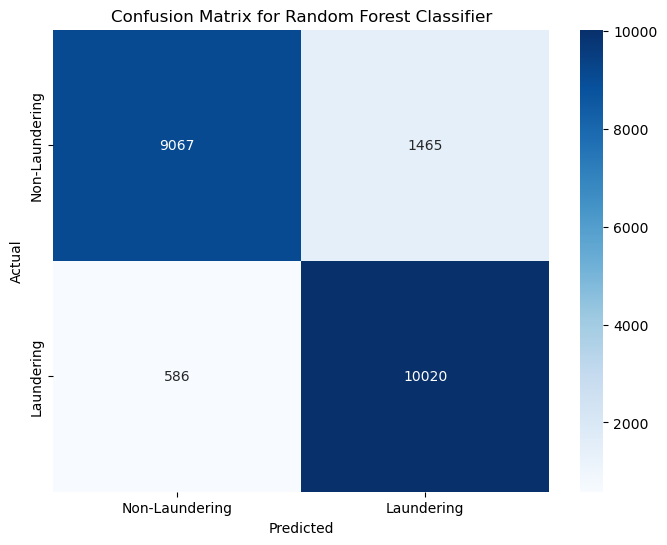

In [72]:
run(new_df)

In [73]:
new_df.shape

(70460, 11)

In [74]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


[0]	train-logloss:0.62245	train-error:0.08323	test-logloss:0.62508	test-error:0.10753
[1]	train-logloss:0.56321	train-error:0.07396	test-logloss:0.56848	test-error:0.10185
[2]	train-logloss:0.51318	train-error:0.06971	test-logloss:0.52168	test-error:0.10323
[3]	train-logloss:0.47035	train-error:0.06541	test-logloss:0.48197	test-error:0.10039
[4]	train-logloss:0.43486	train-error:0.06460	test-logloss:0.44927	test-error:0.10114
[5]	train-logloss:0.40397	train-error:0.06228	test-logloss:0.42179	test-error:0.10176
[6]	train-logloss:0.37641	train-error:0.06174	test-logloss:0.39665	test-error:0.10148
[7]	train-logloss:0.35245	train-error:0.06030	test-logloss:0.37602	test-error:0.10129
[8]	train-logloss:0.33156	train-error:0.05866	test-logloss:0.35796	test-error:0.10124
[9]	train-logloss:0.31204	train-error:0.05718	test-logloss:0.34100	test-error:0.10148
[10]	train-logloss:0.29476	train-error:0.05634	test-logloss:0.32580	test-error:0.10138
[11]	train-logloss:0.28014	train-error:0.05584	test-l

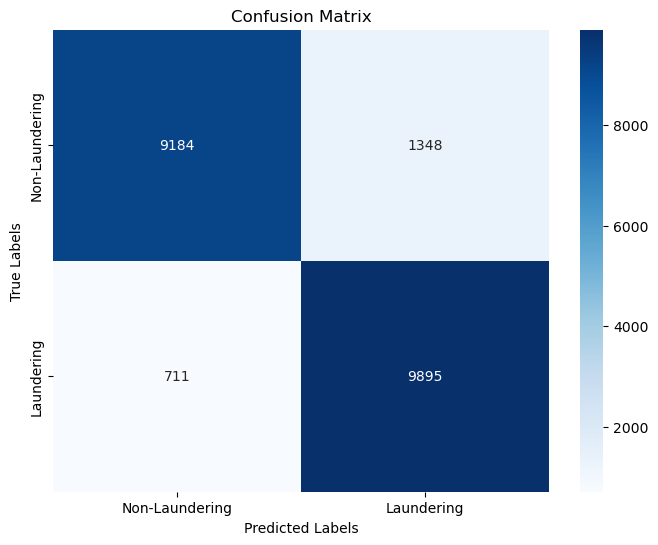

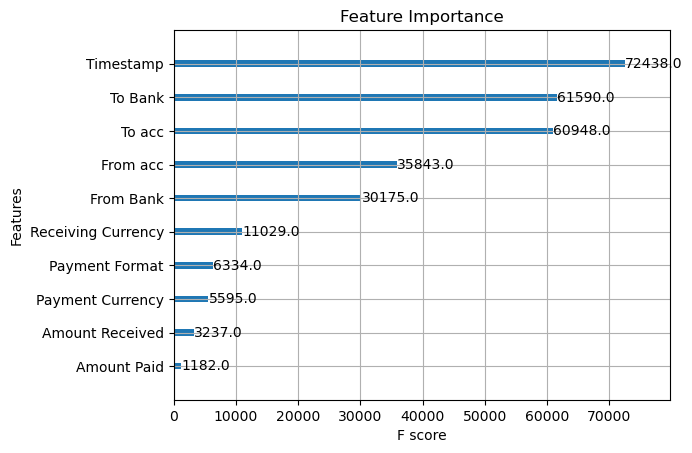

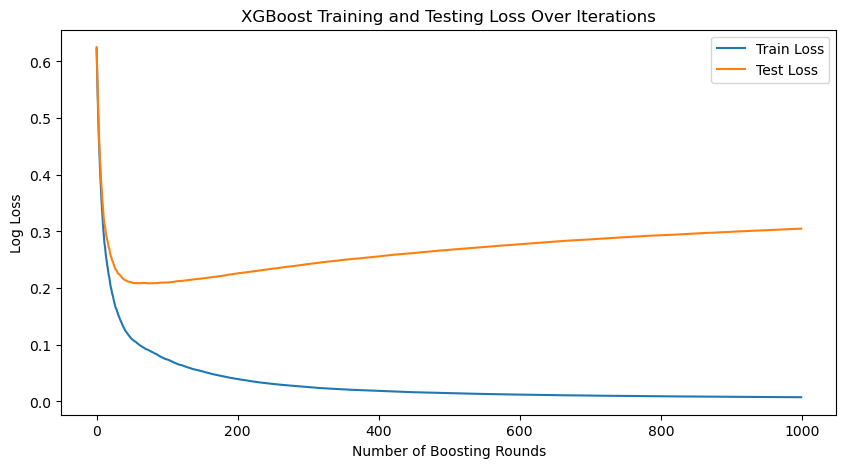

In [82]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
# Assuming 'new_df' is already loaded and preprocessed appropriately
X = new_df.drop('Is Laundering', axis=1)
y = new_df['Is Laundering']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the hyperparameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'error'],
    'eta': 0.1,
    'max_depth': 16,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 0.1,
    'lambda': 1,
}

# Number of boosting rounds
num_rounds = 1000

# Specify validations set to watch performance
watchlist = [(dtrain, 'train'), (dtest, 'test')]
eval_results = {}

# Train the XGBoost model and record the evaluation results
bst = xgb.train(params, dtrain, num_rounds, evals=watchlist, evals_result=eval_results)

# Evaluate the XGBoost model
y_pred = bst.predict(dtest)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)  # Convert probabilities to binary output
test_score = accuracy_score(y_test, y_pred_binary)
print(f"XGBoost Test Accuracy: {test_score * 100:.2f}%")

print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Creating a visually interactive confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Laundering', 'Laundering'], 
            yticklabels=['Non-Laundering', 'Laundering'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Plotting feature importance
xgb.plot_importance(bst)
plt.title('Feature Importance')
plt.show()

# Extract and plot training loss from the evaluation results
train_losses = eval_results['train']['logloss']
test_losses = eval_results['test']['logloss']
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.title('XGBoost Training and Testing Loss Over Iterations')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Log Loss')
plt.show()

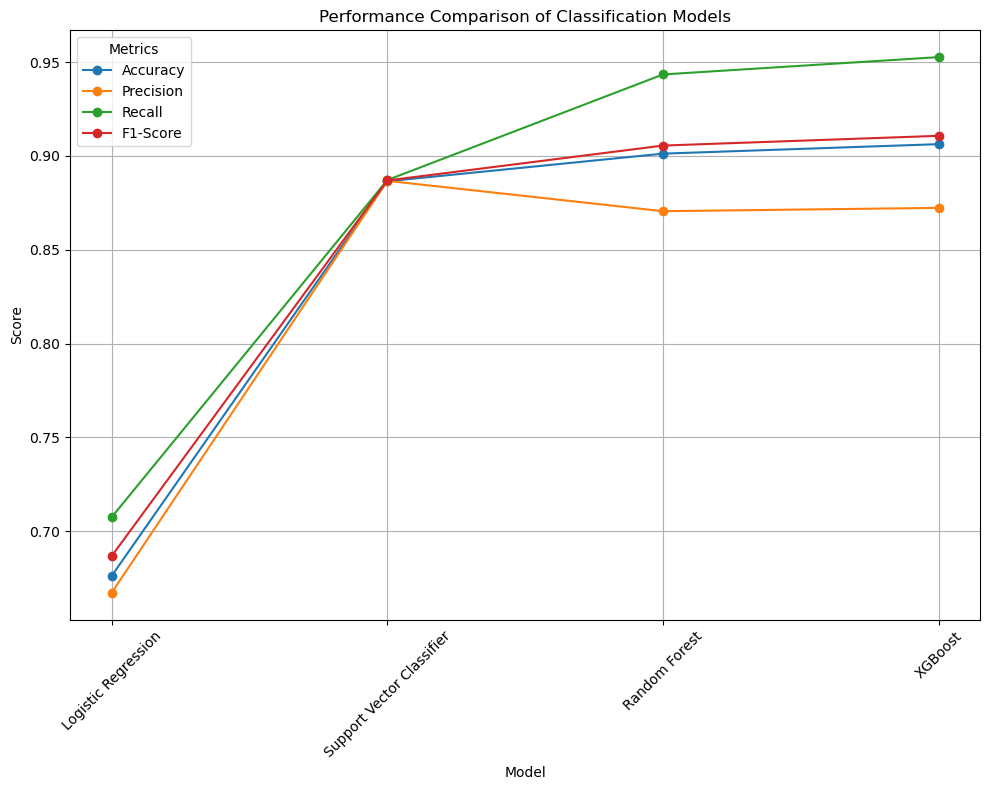

In [80]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import xgboost as xgb

# Assuming 'data' is your DataFrame
X = new_df.drop('Is Laundering', axis=1)
y = new_df['Is Laundering']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Classifier": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": xgb.XGBClassifier(eval_metric='logloss')
}

# Metrics storage
metrics = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": []
}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else clf.decision_function(X_test)

    # Store metrics
    metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
    metrics["Precision"].append(precision_score(y_test, y_pred, zero_division=0))
    metrics["Recall"].append(recall_score(y_test, y_pred))
    metrics["F1-Score"].append(f1_score(y_test, y_pred))

# Convert to DataFrame for easier plotting
metrics_df = pd.DataFrame(metrics, index=classifiers.keys())

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
metrics_df.plot(kind='line', marker='o', ax=ax)
plt.title('Performance Comparison of Classification Models')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(np.arange(len(classifiers)), classifiers.keys(), rotation=45)
plt.grid(True)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()